# Getting Started with `frame`

This notebook illustrates a complete example of how to run `frame` on a dataset of North American gray wolves published in [Schweizer et al. 2015](https://onlinelibrary.wiley.com/doi/full/10.1111/mec.13364?casa_token=idW0quVPOU0AAAAA%3Ao_ll85b8rDbnW3GtgVeeBUB4oDepm9hQW3Y445HI84LC5itXsiH9dGO-QYGPMsuz0b_7eNkRp8Mf6tlW).

## Imports

First we import the required packages and `frame`:

In [1]:
# base
import numpy as np
import pkg_resources
import pandas as pd
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink

# visualization
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# FRAME
from frame.utils import prepare_graph_inputs
from frame.cross_validation import run_cv
from frame import SpatialDiGraph, Vis, Digraphstats

## Data

Note we have packaged this example dataset in the `frame` package and use the `pkg_resources` package to find the path of those files:

In [2]:
data_path = pkg_resources.resource_filename("frame", "data/")

Next we read the genotype data:

In [3]:
# read the genotype data 
genotypes = np.loadtxt('{}/wolf.txt'.format(data_path))

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

n_samples=111, n_snps=17728


As we can see we have 111 samples and 17,729 SNPs. Here the 'wolf.txt' is already in the correct format, where the rows are the individuals, the columns are the snps, and the entries are the copy numbers. This kind of genotype data can be easily adapted from `plink` files:

In [4]:
(bim, fam, G) = read_plink("{}/wolf".format(data_path));
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_128193/1790864960.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, G) = read_plink("{}/wolf".format(data_path));
/tmp/ipykernel_128193/1790864960.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, G) = read_plink("{}/wolf".format(data_path));
Mapping files: 100%|██████████| 3/3 [00:00<00:00, 84.74it/s]


For preparing the graph inputs to run `frame` you have two options:

* Prepare your own input files
* Use the `frame` function `prepare_graph_inputs` which intersects a discrete global grid (DGG) with the sample range

Here we'll show off the later option. We read the sample coordinates, coordinates of the outer polygon that defines the habitat of the sample and a discrete global grid file which has laid down a triangular grid that is uniformly spaced on earth. We then intersect this global grid with the outer file to define the graph that we use to optimize:

In [5]:
%%time
# setup graph
coord = np.loadtxt("{}/wolf.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolf.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid250.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             buffer=0,
                                             outer=outer)

CPU times: user 384 ms, sys: 6.11 ms, total: 390 ms
Wall time: 410 ms


## Setup the `SpatialDiGraph` object

We then setup the `SpatialDiGraph` object which is the core workhorse of `frame`. `SpatialDiGraph` specifies the graph, allele frequency data, and runs the optimizers to fit the edge weights of the digraph:

In [6]:
%%time
sp_digraph = SpatialDiGraph(genotypes, coord, grid, edges)

CPU times: user 109 ms, sys: 24.6 ms, total: 134 ms
Wall time: 95.9 ms


This might take a few minutes to construct at first b/c it initializing a number of graph matrices that are slow to build. First, before any fitting we'll visualize the graph and samples. Lets setup the projection we'll be using for this dataset:

In [7]:
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)

## Run cross validation

Next we perform 10-fold cross-validation over $\lambda$ through a two-stage grid search. In our CV we hold out individual observed nodes on the digraph, predict allele frequencies at the held-out node under our fitted model, and use the $\ell_2$ distance between the fitted and predicted allele frequencies as our CV metric to select models. We first do a rough search and determine the range of the fine grid search:

In [8]:
lamb_warmup = 1e3

lamb_grid = np.geomspace(1e-3, 1e3,13)[::-1]

cv,node_train_idxs=run_cv(sp_digraph,
                          lamb_grid,
                          lamb_warmup=lamb_warmup,
                          n_folds=10,
                          factr=1e10,
                          random_state=500,
                          outer_verbose=True,
                          inner_verbose=False,)

if np.argmin(cv)==0:
   lamb_grid_fine=np.geomspace(lamb_grid[0],lamb_grid[1],7)[::-1]

elif np.argmin(cv)==12:
     lamb_grid_fine=np.geomspace(lamb_grid[11],lamb_grid[12], 7)[::-1]
     
else:
    lamb_grid_fine=np.geomspace(lamb_grid[np.argmin(cv)-1],lamb_grid[np.argmin(cv)+1], 7)[::-1]


 fold= 1
iteration lambda=13/13
 fold= 2
iteration lambda=13/13
 fold= 3
iteration lambda=13/13
 fold= 4
iteration lambda=13/13
 fold= 5
iteration lambda=13/13
 fold= 6
iteration lambda=13/13
 fold= 7
iteration lambda=13/13
 fold= 8
iteration lambda=13/13
 fold= 9
iteration lambda=13/13
 fold= 10
iteration lambda=13/13

We then do a fine grid search and pick the optimal $\lambda$ value:

In [9]:
cv_fine,node_train_idxs_fine=run_cv(sp_digraph,
                                    lamb_grid_fine,
                                    lamb_warmup=lamb_warmup,
                                    n_folds=10,
                                    factr=1e10,
                                    random_state=500,
                                    outer_verbose=True,
                                    inner_verbose=False,
                                    node_train_idxs=node_train_idxs)

lamb_opt=lamb_grid_fine[np.argmin(cv_fine)]
lamb_opt=float("{:.3g}".format(lamb_opt))


 fold= 1
iteration lambda=7/7
 fold= 2
iteration lambda=7/7
 fold= 3
iteration lambda=7/7
 fold= 4
iteration lambda=7/7
 fold= 5
iteration lambda=7/7
 fold= 6
iteration lambda=7/7
 fold= 7
iteration lambda=7/7
 fold= 8
iteration lambda=7/7
 fold= 9
iteration lambda=7/7
 fold= 10
iteration lambda=7/7

The CV error can be ploted as following:

Text(0, 0.5, 'CV Error')

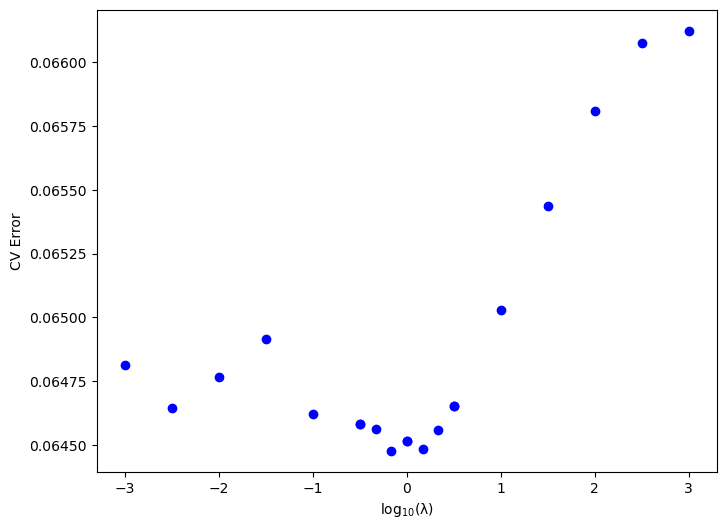

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(np.log10(lamb_grid), cv, 'bo')  
plt.plot(np.log10(lamb_grid_fine), cv_fine, 'bo')  
plt.xlabel(r"$\mathrm{log}_{10}(\mathrm{\lambda})$")
plt.ylabel('CV Error')

## Fit `FRAME`

Next we fit the `FRAME` model with the optimal $\lambda$. To be consistent with the cross validation step, we use the warm up fitting as the intial value and then fit with stricter converging criteria: 

In [11]:
%%time
sp_digraph.fit(lamb=lamb_warmup, factr=1e10)
logm = np.log(sp_digraph.m)
logc = np.log(sp_digraph.c)

sp_digraph.fit(lamb=lamb_opt,
               factr=1e7,
               logm_init=logm,
               logc_init=logc,
               )

lambda=1000.0000000, converged in 50 iterations, train_loss=-783197.8371280
lambda=0.6810000, converged in 468 iterations, train_loss=-800008.6240180
CPU times: user 1min 44s, sys: 16 s, total: 2min
Wall time: 1min 17s


## Visualize results

Now we can visualize the results:

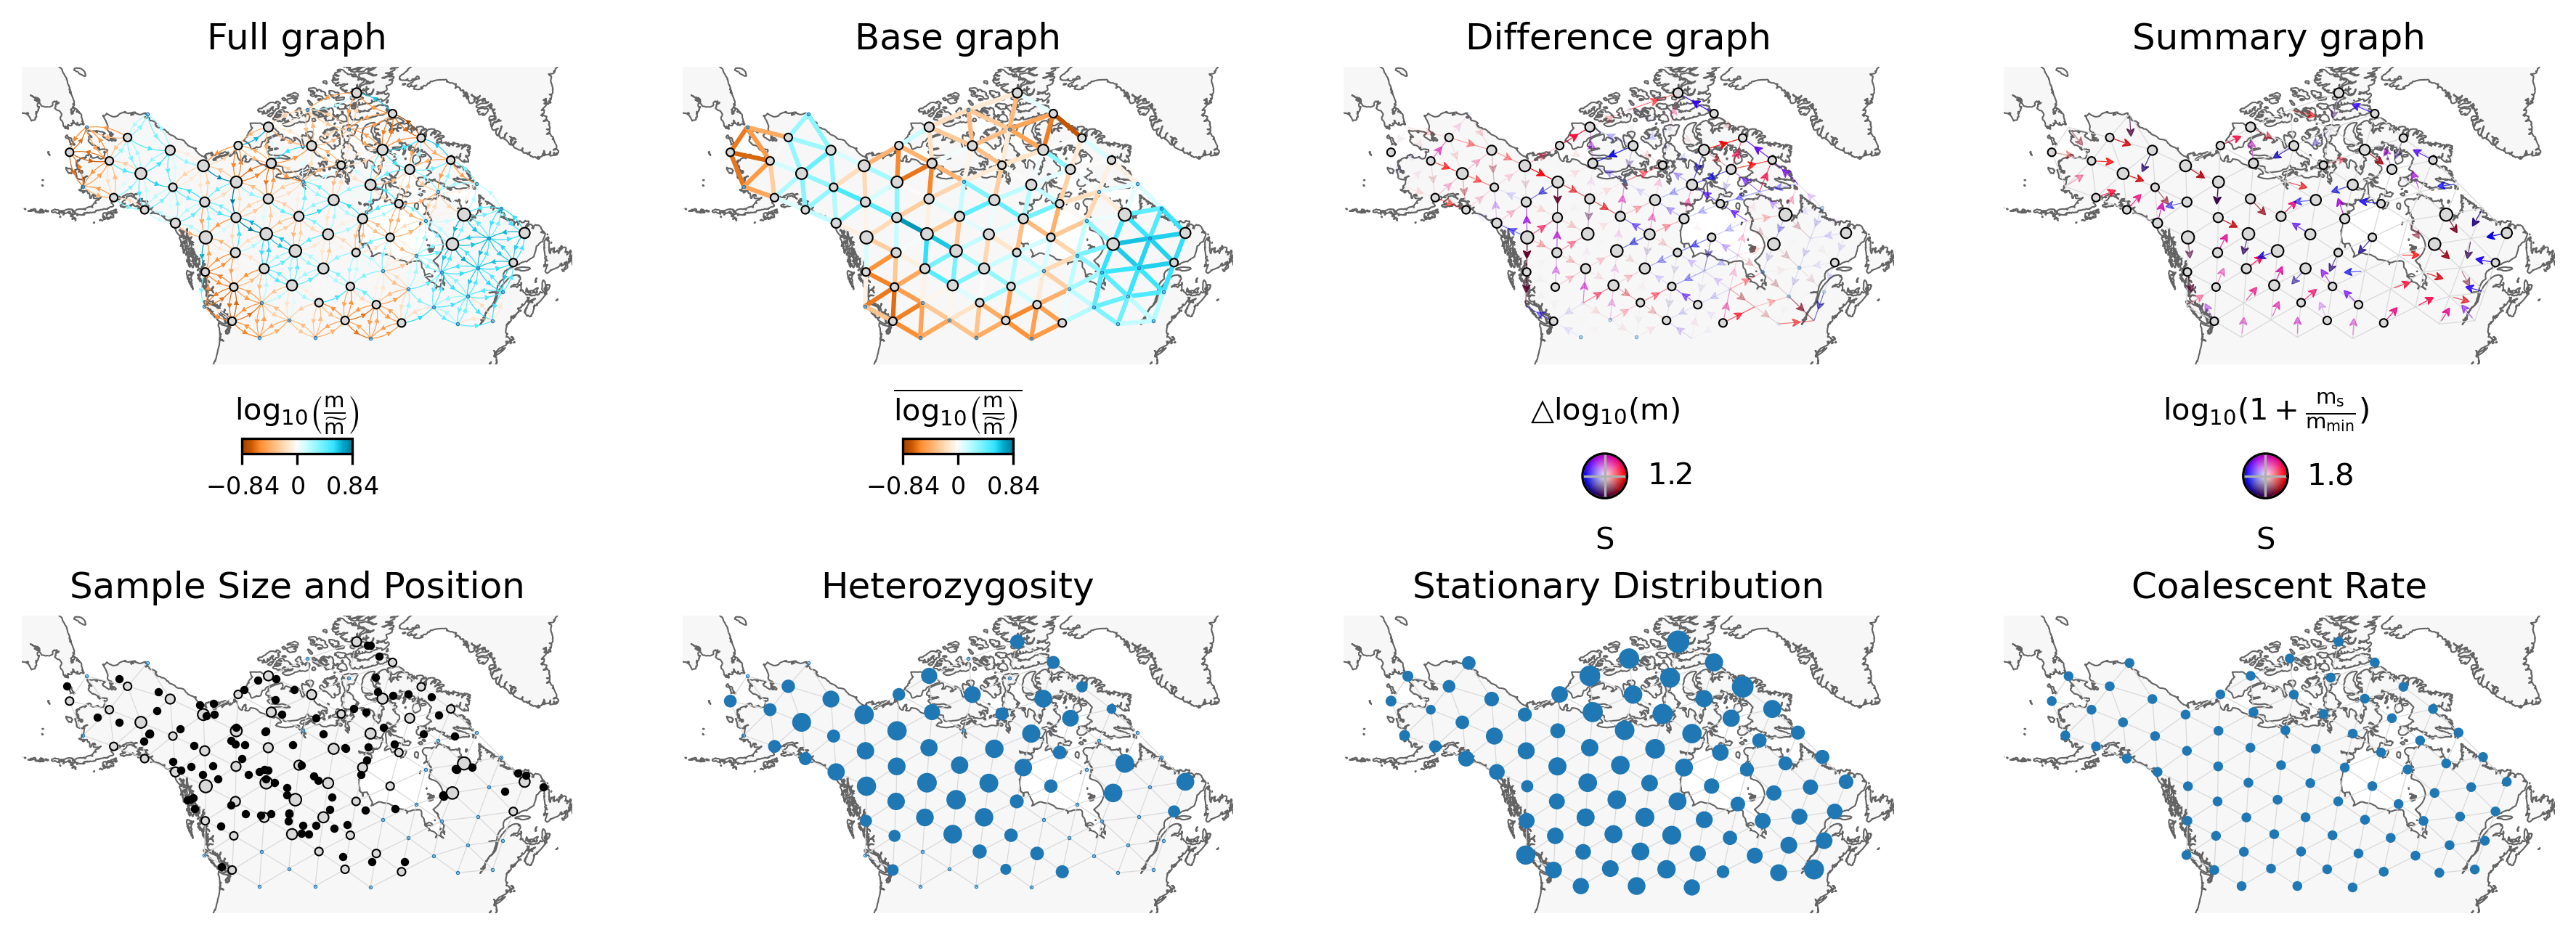

In [12]:
fig, axs= plt.subplots(2, 4, figsize=(15, 6), dpi=300,
                        subplot_kw={'projection': projection})

v = Vis(axs[0,0], sp_digraph, projection=projection, edge_width=0.3,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20,
        obs_node_size=5, sample_pt_color="black",
        cbar_font_size=10,cbar_loc='lower center', cbar_ticklabelsize=8, 
        cbar_bbox_to_anchor=(0.0, -0.3, 1, 1),   
        campass_bbox_to_anchor=(0.4, -0.45), mutation_scale=3)

v.digraph_wrapper(axs, node_scale=[5, 5, 5])

The `digraph_wrapper` function shows all the representations and attributes in a single figure. If we want to draw them seperately, we can use `draw_migration_rates` function and `draw_attributes` function, with a specification of the graph mode (`Full`,`Base`,  `Difference`, `Summary`) and attributes (`Sample Size and Position`, `Heterozygosity`,`Stationary Distribution`,`Coalescent Rate`). For example, we can show the difference graph and stationary distribution through:

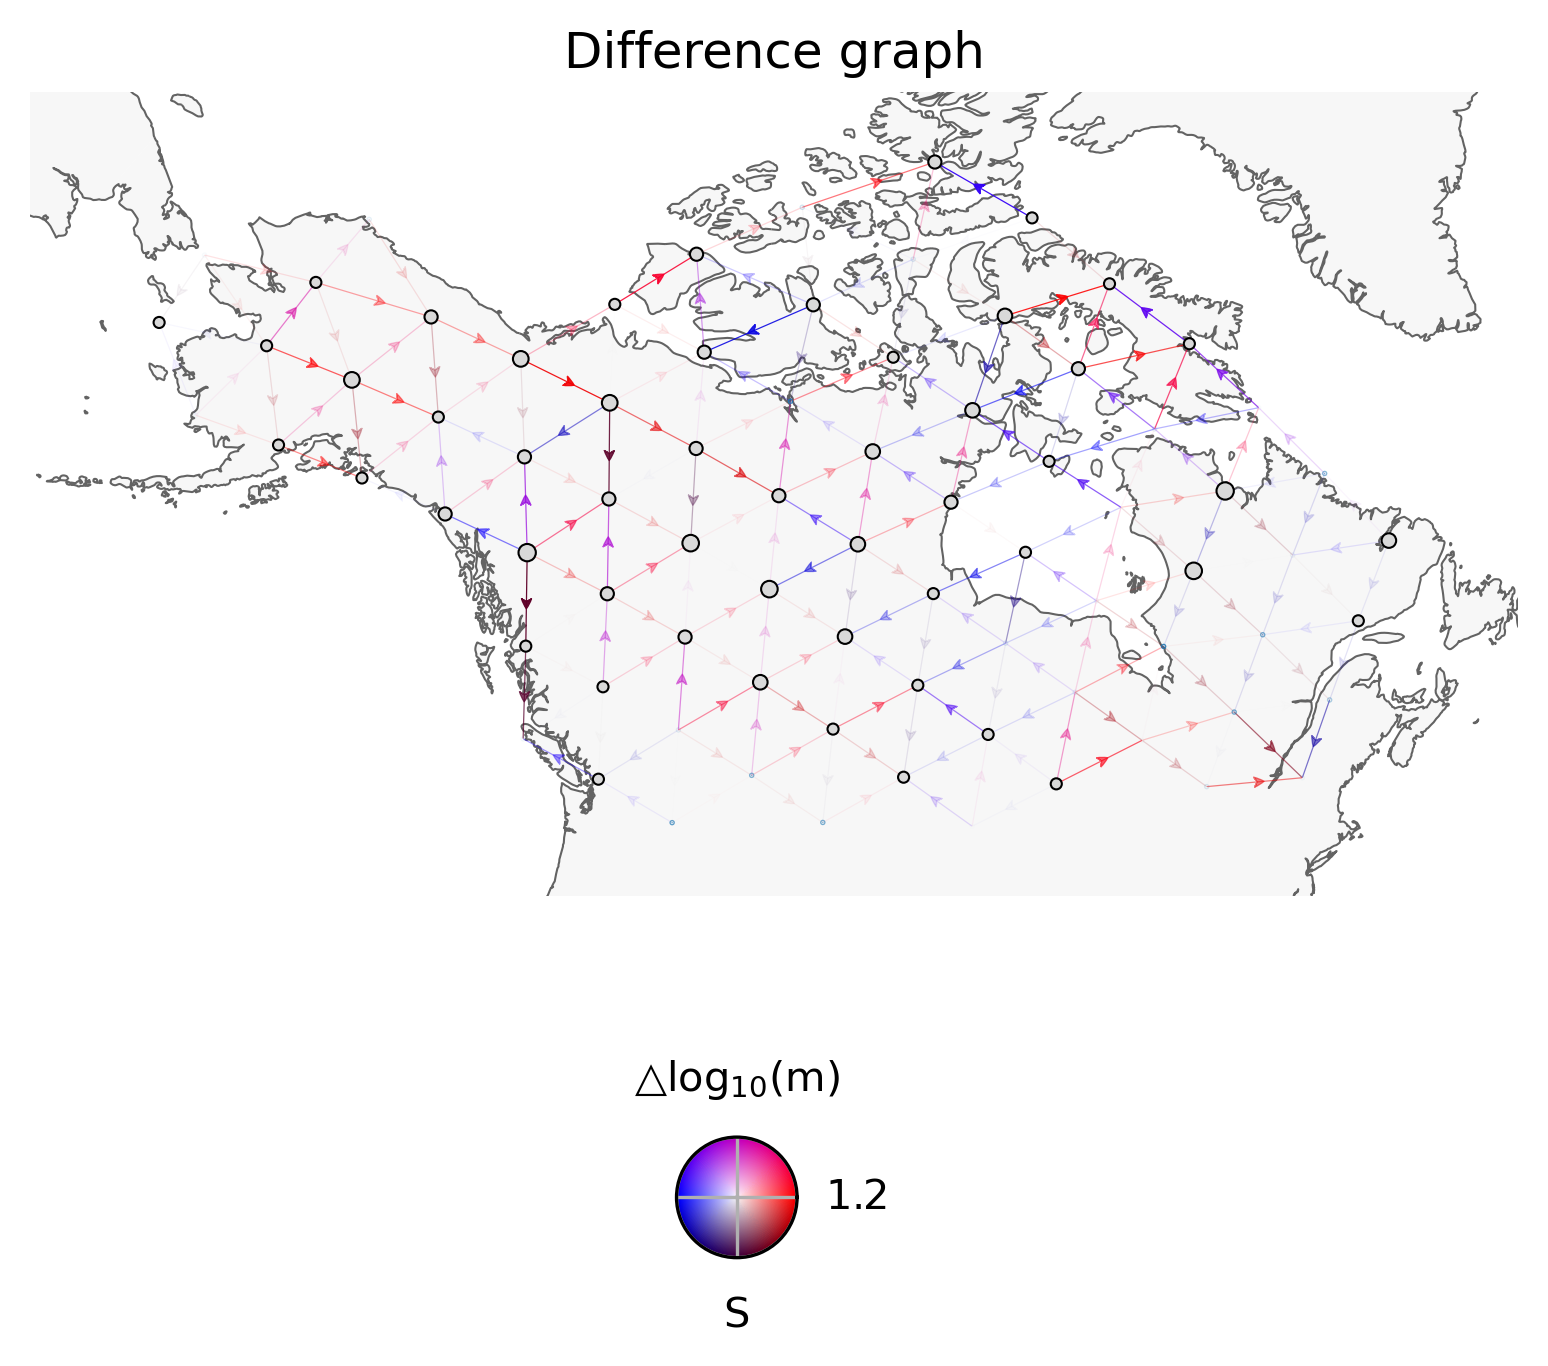

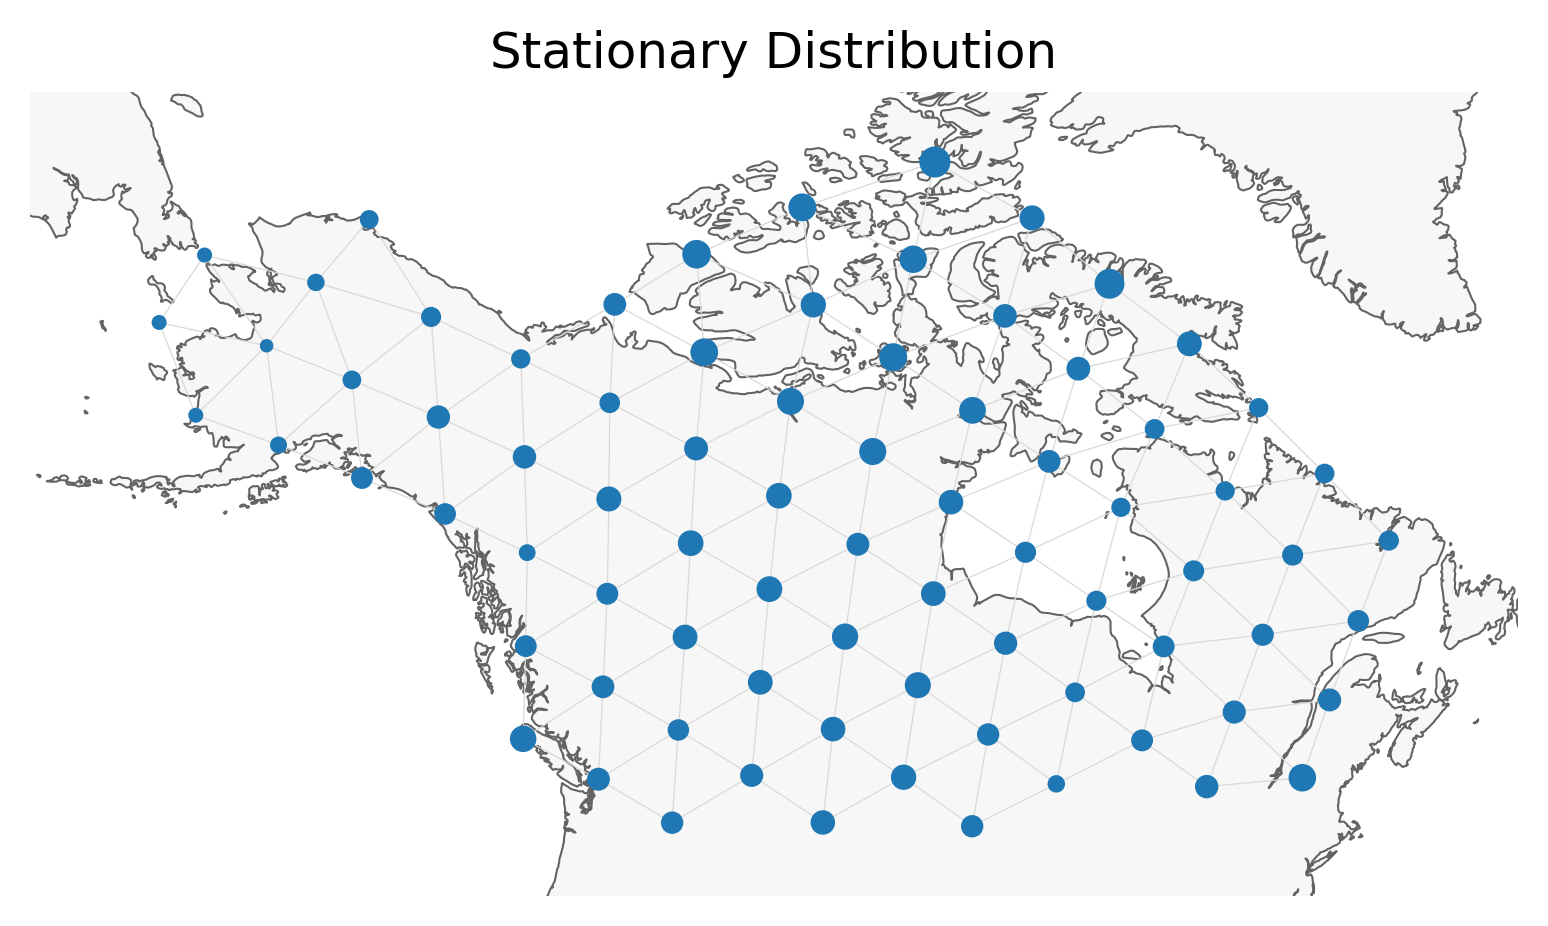

In [13]:
fig = plt.figure(dpi=300)
ax= fig.add_subplot(1, 1, 1, projection=projection)
v.draw_migration_rates(ax,
                       mode='Difference',
                       draw_map=True,
                       draw_nodes=True,)

fig= plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection) 
v.draw_attributes(ax,
                  node_scale=5,
                  attribute='Stationary Distribution',
                  draw_map=True,)

We can also compare the fitted distances with the observed genetic distances:

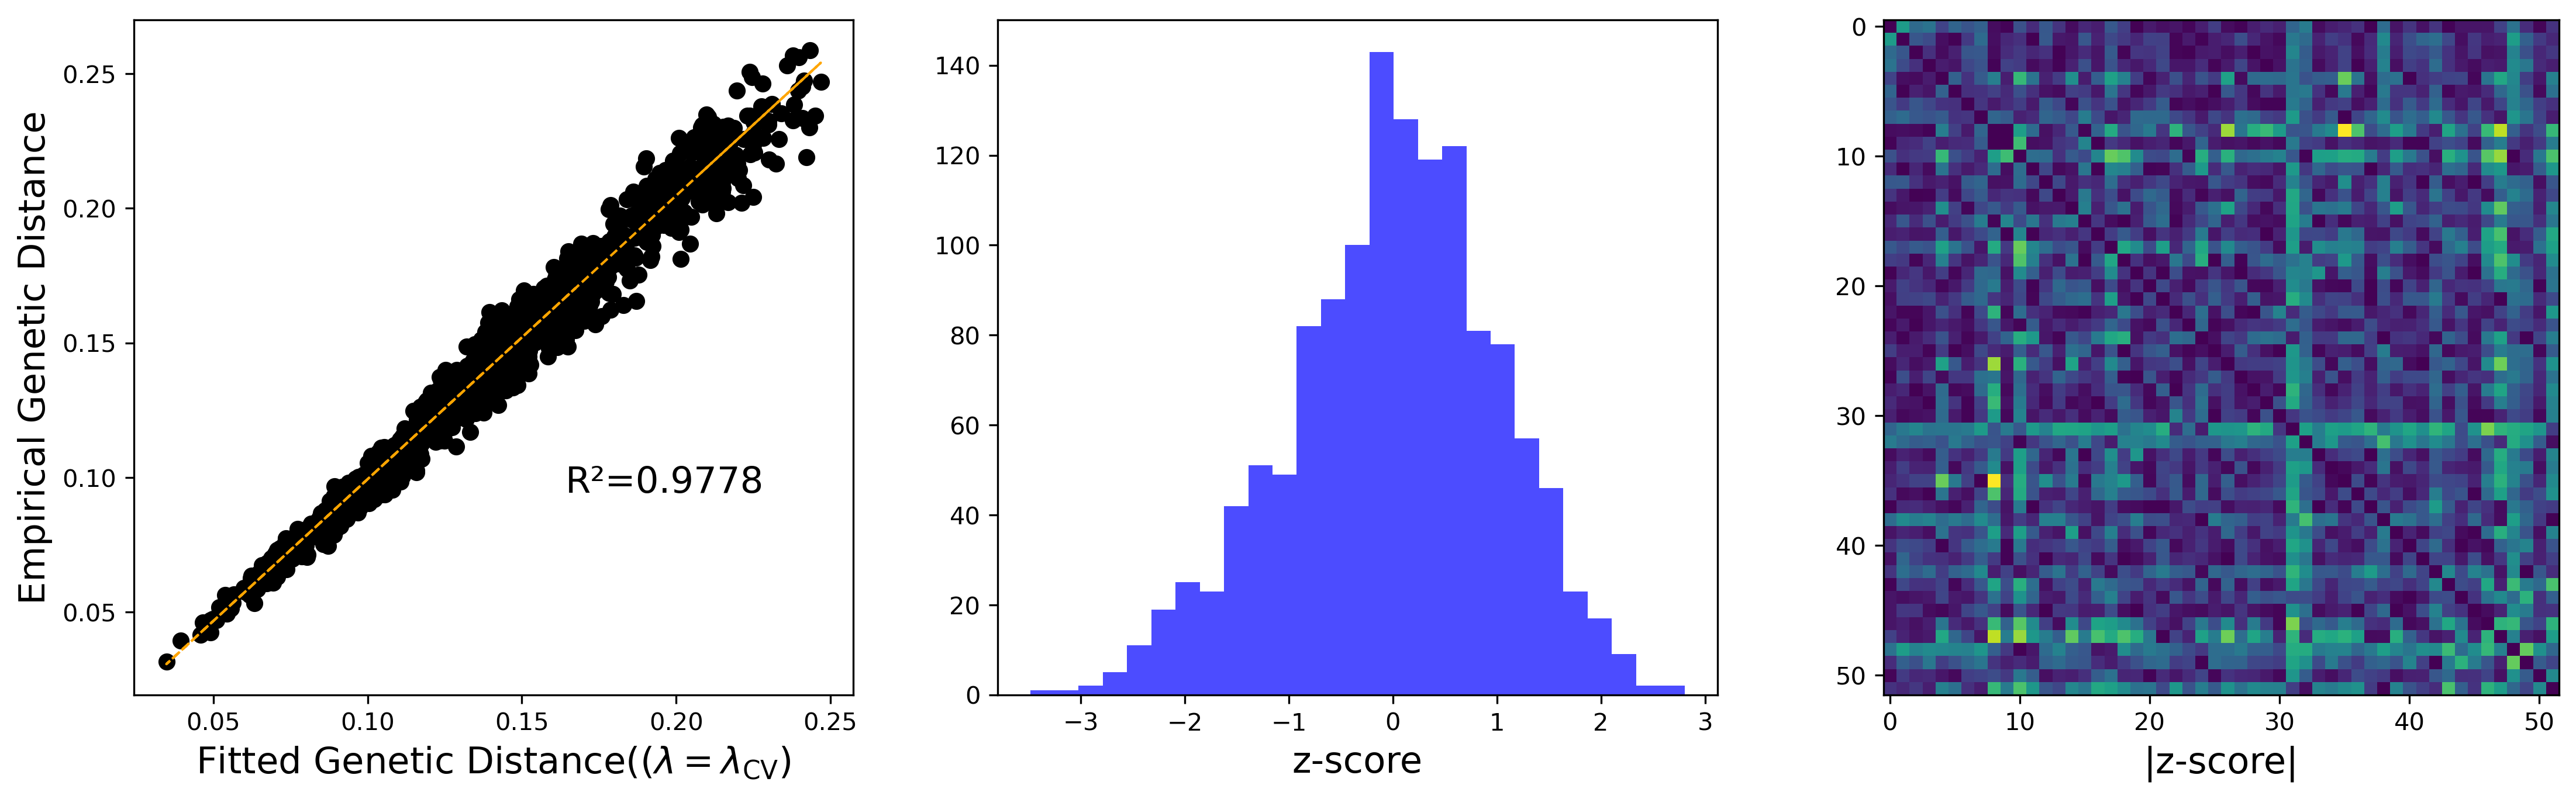

In [14]:
digraphstats = Digraphstats(sp_digraph)

fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=300)
digraphstats.fitting_wrapper(axs)
plt.show()

The `fitting_wrapper` function combines the regression of distances, z-score distribution and heatmap. We can also draw the figures seperately through:

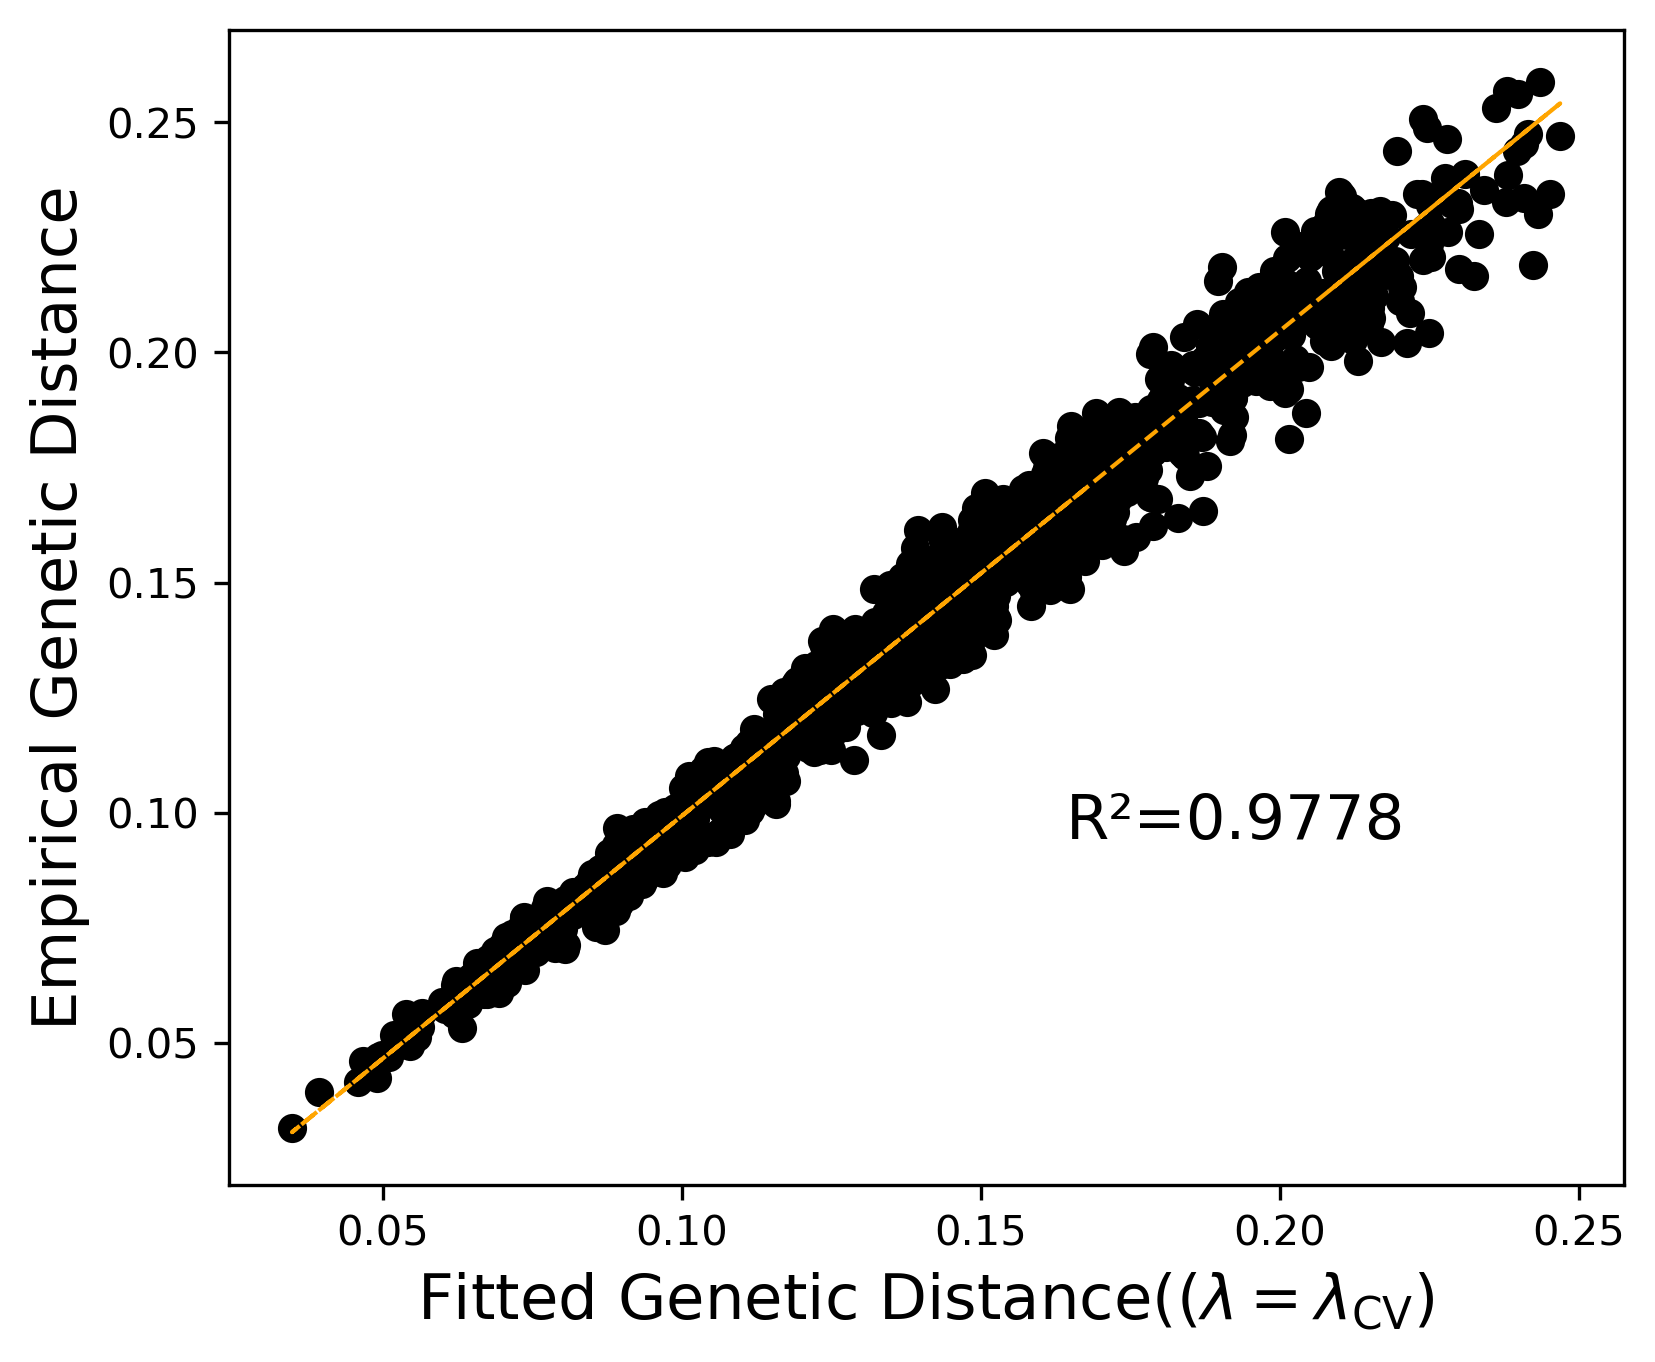

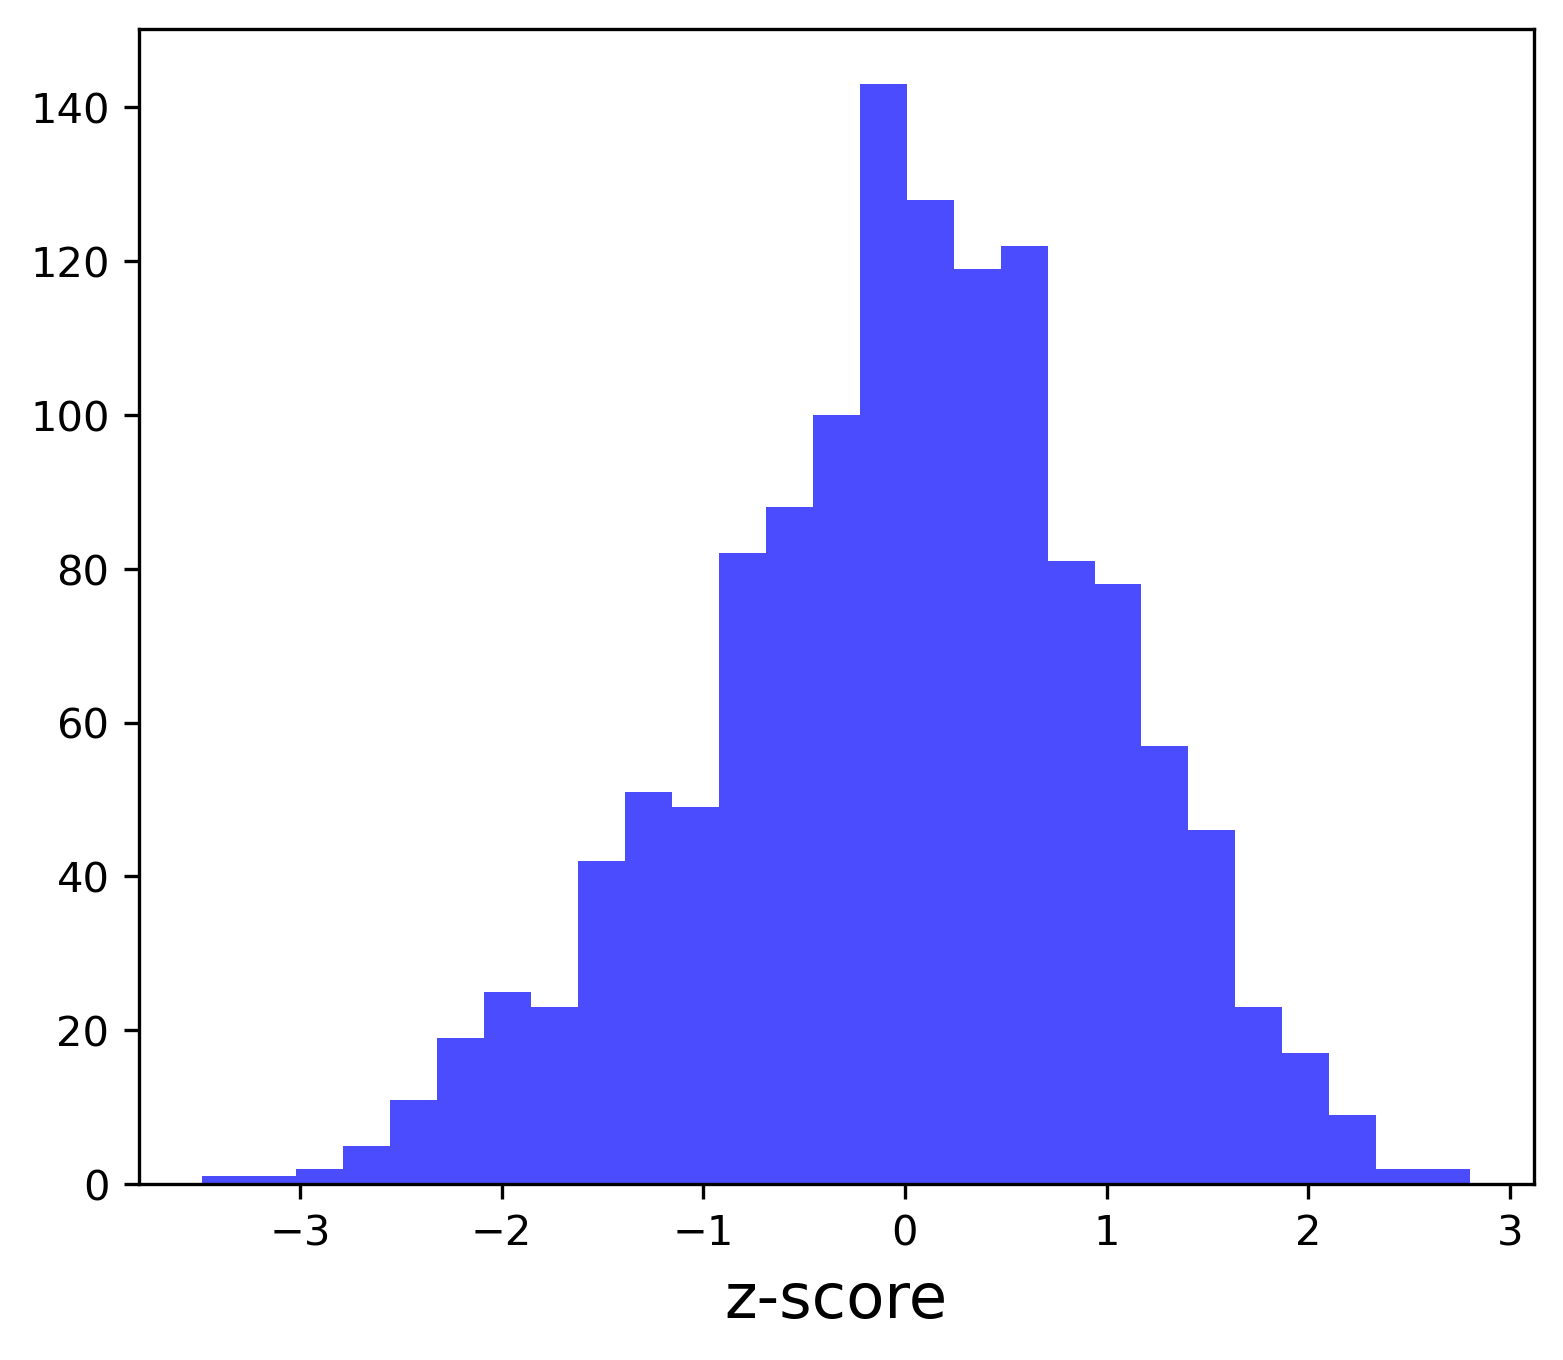

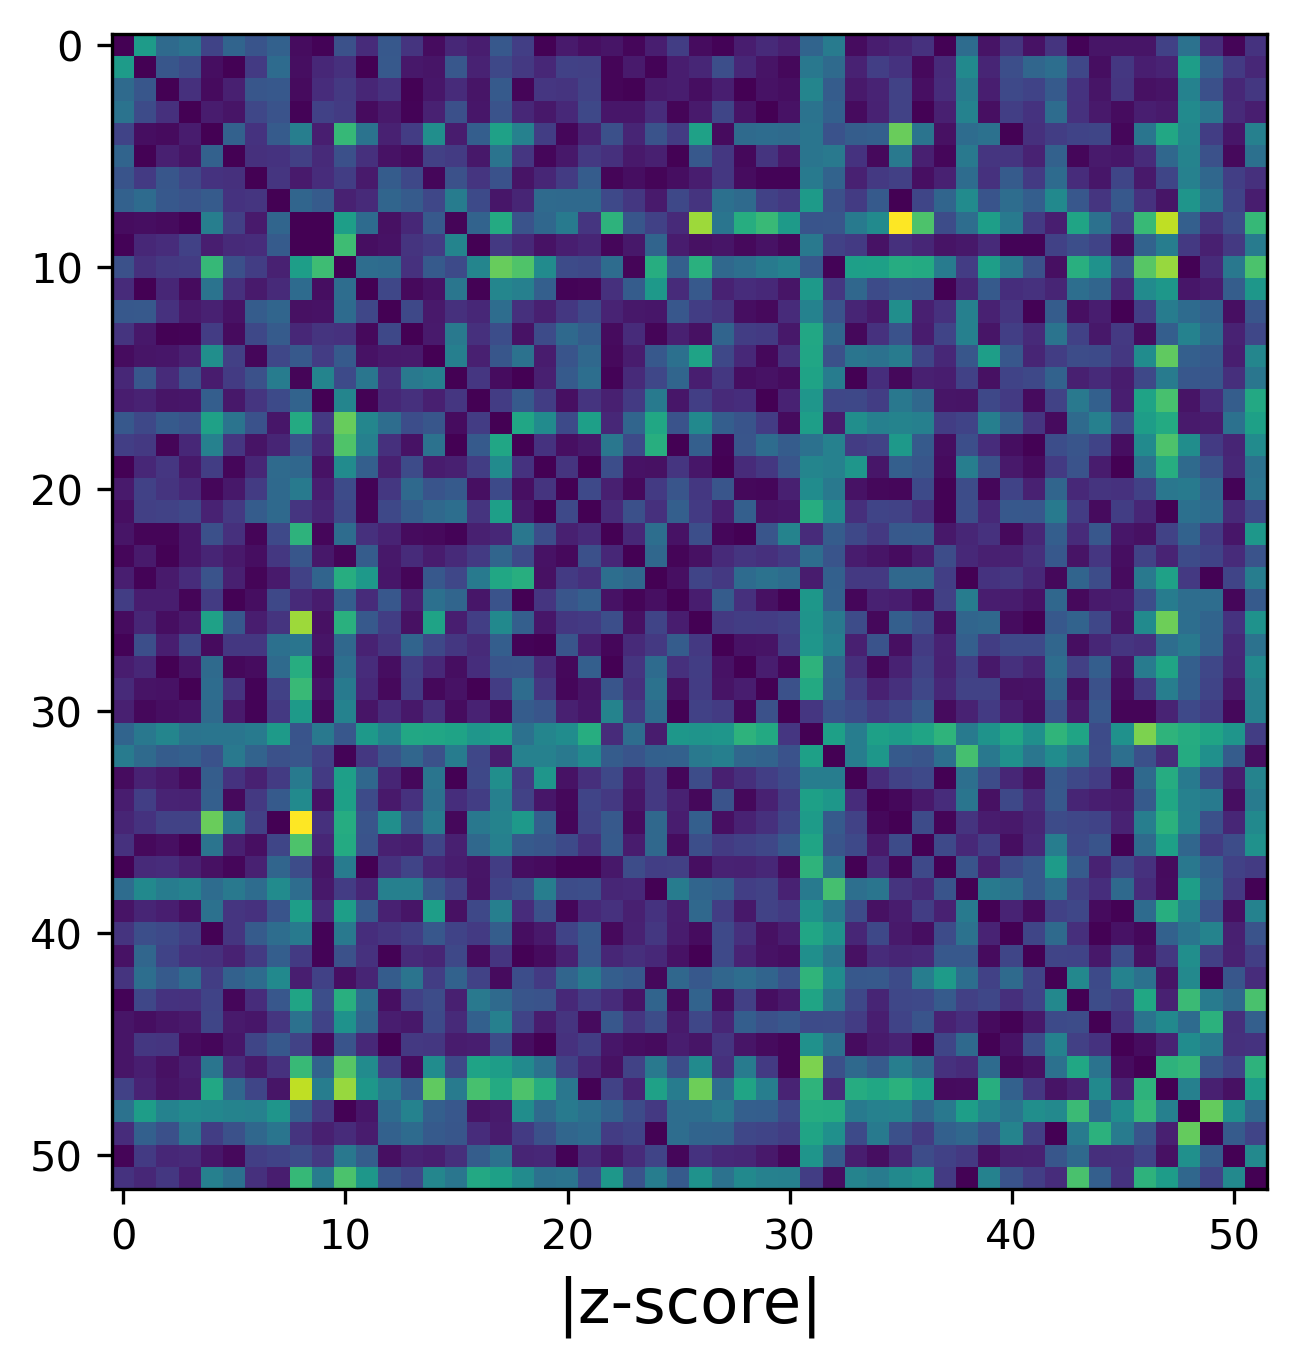

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=300)
digraphstats.distance_regression(ax)

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=300)
digraphstats.z_score_distribution(ax)

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=300)
digraphstats.draw_heatmap(ax)

Great ... now we finish our first `FRAME` analysis! We essentially provided these results interactively! For more interpretation of these  figures and method please see our pre-print :)